# Text classification with Transformer

**Author:** [Apoorv Nandan](https://twitter.com/NandanApoorv), modified by Priyanka A<br>
**Date created:** 2020/05/10<br>
**Last modified:** 2024/11/29<br>
**Original Description:** Implement a Transformer block as a Keras layer and use it for text classification.

**Modified version:** Modified the code such that the TansformerBlock contains two encoder blocks stacked for performing classication.

## Setup

In [1]:
import keras
from keras import ops
from keras import layers
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


## Implement a Transformer block as a layer

In [2]:
class TransformerBlock(layers.Layer):
    """
    A Transformer block that includes multi-head self-attention and feed-forward layers.

    Args:
    - embed_dim (int): The dimensionality of the input embedding.
    - num_heads (int): The number of attention heads in the multi-head attention layer.
    - ff_dim (int): The dimensionality of the feed-forward network.
    - rate (float): Dropout rate (default is 0.1).
    """
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        """
        Forward pass of the Transformer block.

        Args:
        - inputs (tensor): Input tensor to the Transformer block.
        - training (bool): Flag indicating whether the model is in training mode.

        Returns:
        - tensor: Output tensor after applying multi-head attention, feed-forward layers, and normalization.
        """
        attn_output = self.att(inputs, inputs)  # Self-attention layer
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # Add & normalize
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

## Implement embedding layer

Two  embedding layers, one for tokens, one for token index (positions).

In [3]:
class TokenAndPositionEmbedding(layers.Layer):
    """
    Token and Position Embedding layer that combines token embeddings with position embeddings.

    Args:
    - maxlen (int): Maximum sequence length.
    - vocab_size (int): Vocabulary size.
    - embed_dim (int): Dimensionality of the embedding.
    """
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        """
        Add token and position embeddings to the input tensor.

        Args:
        - x (tensor): Input tensor to be embedded.

        Returns:
        - tensor: Tensor after adding position embeddings to token embeddings.
        """
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

## Download and prepare dataset

In [4]:
def load_and_prepare_data(vocab_size=20000, maxlen=200):
    """
    Loads and prepares the IMDB dataset for training.

    Args:
    - vocab_size (int): The number of words to consider in the vocabulary.
    - maxlen (int): Maximum number of words in a review.

    Returns:
    - tuple: Training and validation data (x_train, y_train), (x_val, y_val).
    """
    (x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
    x_train = keras.utils.pad_sequences(x_train, maxlen=maxlen)
    x_val = keras.utils.pad_sequences(x_val, maxlen=maxlen)
    return (x_train, y_train), (x_val, y_val)

(x_train, y_train), (x_val, y_val) = load_and_prepare_data()


## Create classifier model using transformer layer



In [5]:
# Build the Transformer model with two stacked Transformer blocks
def build_transformer_model(embed_dim=32, num_heads=2, ff_dim=32, maxlen=200, vocab_size=20000):
    """
    Builds a text classification model using stacked Transformer blocks.

    Args:
    - embed_dim (int): Embedding dimension for each token.
    - num_heads (int): Number of attention heads.
    - ff_dim (int): Feed-forward layer size.
    - maxlen (int): Maximum sequence length.
    - vocab_size (int): Vocabulary size.

    Returns:
    - model: Compiled Keras model.
    """
    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)

    # First Transformer block
    transformer_block1 = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block1(x, training=True)

    # Second Transformer block
    transformer_block2 = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block2(x, training=True)

    # Final layers for classification
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(20, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(2, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    return model

model = build_transformer_model()

## Train and Evaluate

In [6]:
# Train the model
def train_model(model, x_train, y_train, x_val, y_val, epochs=2, batch_size=32):
    """
    Compiles and trains the Transformer model.

    Args:
    - model (Keras Model): The model to be trained.
    - x_train (ndarray): Training data.
    - y_train (ndarray): Training labels.
    - x_val (ndarray): Validation data.
    - y_val (ndarray): Validation labels.
    - epochs (int): Number of epochs to train the model.
    - batch_size (int): Batch size.

    Returns:
    - history: Training history object.
    """
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val))
    return history

train_model(model, x_train, y_train, x_val, y_val)


Epoch 1/2
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.7182 - loss: 0.5070 - val_accuracy: 0.8688 - val_loss: 0.2994
Epoch 2/2
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9377 - loss: 0.1713 - val_accuracy: 0.8710 - val_loss: 0.3296


782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


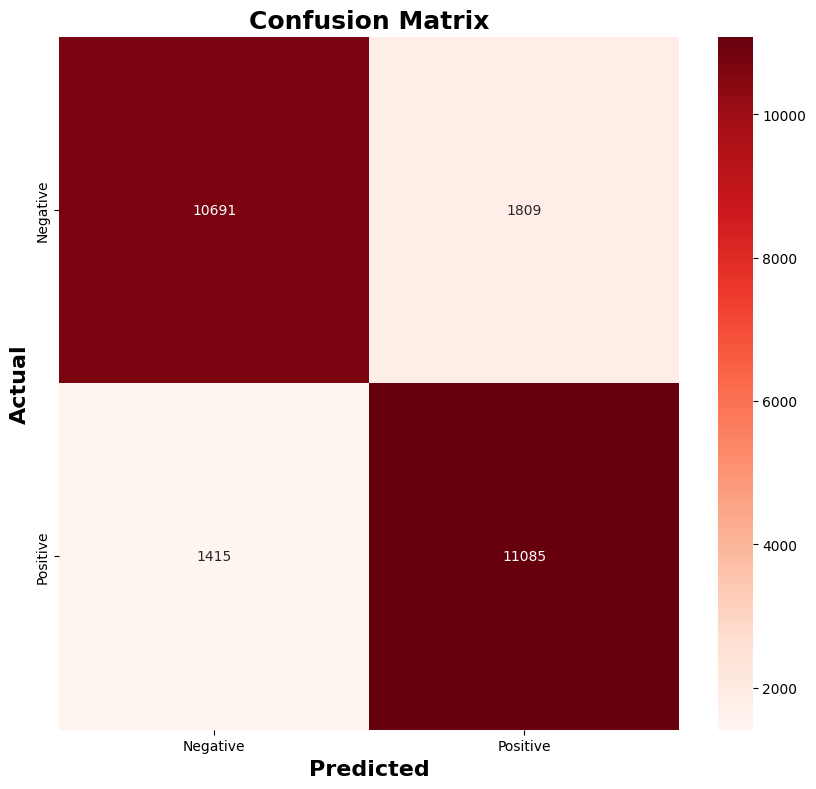

Precision: 0.8597
Recall: 0.8868
F1-Score: 0.8730


In [7]:

# Evaluate model and plot metrics
def evaluate_model(model, x_val, y_val):
    """
    Evaluates the model on the validation set and plots metrics.

    Args:
    - model (Keras Model): The trained model.
    - x_val (ndarray): Validation data.
    - y_val (ndarray): Validation labels.
    """
    y_pred = model.predict(x_val)
    y_pred = y_pred.argmax(axis=1)  # Convert predictions to class labels

    # Generate confusion matrix
    cm = confusion_matrix(y_val, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 9))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel('Predicted', fontsize=16, fontweight='bold')
    plt.ylabel('Actual', fontsize=16, fontweight='bold')
    plt.title('Confusion Matrix', fontsize=18, fontweight='bold')
    plt.show()

    # Calculate precision, recall, and F1-score
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

evaluate_model(model, x_val, y_val)
